## Argo File Loader

In [3]:
# try with newest snapshot
# try with ftp that gmaze used in issue, probably going to be really slow

In [1]:
import xarray as xr
import numpy as np
import gsw
import matplotlib.pyplot as plt
import matplotlib as mpl
from importlib import reload
from cmocean import cm as cmo
import xrft
import pandas as pd
import argopy
from argopy import DataFetcher
import dask

In [7]:
print('argopy: {}, xarray: {}, dask: {}'.format(argopy.__version__, xr.__version__, dask.__version__))

argopy: 1.0.0, xarray: 2024.2.0, dask: 2024.10.0


In [2]:
import os
os.chdir('/home.ufs/amf2288/argo-intern/funcs')
import density_funcs as df
import EV_funcs as ef
import filt_funcs as ff
import plot_funcs as pf
import processing_funcs as prf

In [3]:
reload(df)
reload(ef)
reload(ff)
reload(pf)
#reload(mf)
reload(prf)

<module 'processing_funcs' from '/home/amf2288/argo-intern/funcs/processing_funcs.py'>

## testing parallel loading with dask client

In [8]:
from dask.distributed import Client

In [9]:
client= Client(processes=True)

In [10]:
print(client)

<Client: 'tcp://127.0.0.1:40579' processes=9 threads=72, memory=0.98 TiB>


In [11]:
box = [-27.5, -22.5, -5, 5, 0, 2001]

In [12]:
%%time
with argopy.set_options(parallel=client):
    f = DataFetcher(src='gdac', ftp='/swot/SUM05/dbalwada/Argo_sync', progress=True).region(box)
    print('%i chunks to process' % len(f.uri))
    print(f)
    ds = f.load().data#.to_xarray()

261 chunks to process
<datafetcher.gdac>
🌐 Name: Ifremer GDAC Argo data fetcher for a space/time region
🗺  Domain: [x=-27.50/-22.50; y=-5.00/5.00; z=0.0/2001.0]
🔗 API: https://data-argo.ifremer.fr
📗 Index: ar_index_global_prof.txt.gz (3056221 records)
📸 Index searched: True (261 matches, 0.0085%)
🏊 User mode: standard
🟡+🔵 Dataset: phy
🌤  Performances: cache=False, parallel=True [<Client: 'tcp://127.0.0.1:40579' processes=9 threads=72, memory=0.98 TiB>]


2024-11-08 13:41:01,139 - distributed.worker - ERROR - Compute Failed
Key:       _mfprocessor_dataset-73b4bb1bffd1efc58dc47ef9215c2326
State:     executing
Function:  execute_task
args:      ((<function apply at 0x7f8b033f3ba0>, <bound method httpstore._mfprocessor_dataset of <argopy.stores.filesystems.httpstore object at 0x7f8ab4d08bc0>>, (<class 'tuple'>, ['https://data-argo.ifremer.fr/dac/aoml/39007/39007_prof.nc']), {'preprocess': <function pre_process_multiprof at 0x7f8acfd3e7a0>, 'preprocess_opts': {'access_point': 'BOX', 'access_point_opts': {'BOX': [-27.5, -22.5, -5, 5, 0, 2001]}, 'pre_filter_points': True}, 'open_dataset_opts': {'xr_opts': {'decode_cf': 1, 'use_cftime': 0, 'mask_and_scale': 1}}}))
kwargs:    {}
Exception: "ServerDisconnectedError('Server disconnected')"
Traceback: '  File "/home.ufs/amf2288/mambaforge-pypy3/envs/Argo_Nov_24/lib/python3.12/site-packages/dask/utils.py", line 78, in apply\n    return func(*args, **kwargs)\n           ^^^^^^^^^^^^^^^^^^^^^\n  File

ServerDisconnectedError: Server disconnected

2024-11-08 13:41:18,271 - distributed.worker - ERROR - Compute Failed
Key:       _mfprocessor_dataset-915e1748c78d5e2236f26d02cedefeb9
State:     executing
Function:  execute_task
args:      ((<function apply at 0x7f763a3dfba0>, <bound method httpstore._mfprocessor_dataset of <argopy.stores.filesystems.httpstore object at 0x7f75b69f3e00>>, (<class 'tuple'>, ['https://data-argo.ifremer.fr/dac/coriolis/3900282/3900282_prof.nc']), {'preprocess': <function pre_process_multiprof at 0x7f7606d12a20>, 'preprocess_opts': {'access_point': 'BOX', 'access_point_opts': {'BOX': [-27.5, -22.5, -5, 5, 0, 2001]}, 'pre_filter_points': True}, 'open_dataset_opts': {'xr_opts': {'decode_cf': 1, 'use_cftime': 0, 'mask_and_scale': 1}}}))
kwargs:    {}
Exception: "ServerDisconnectedError('Server disconnected')"
Traceback: '  File "/home.ufs/amf2288/mambaforge-pypy3/envs/Argo_Nov_24/lib/python3.12/site-packages/dask/utils.py", line 78, in apply\n    return func(*args, **kwargs)\n           ^^^^^^^^^^^^^^^^^^^^^

Okay the process is running on multiple GPUs, in this case 10-12 machines. However, obviously there are a ton of error messages---I'm not really sure what's going wrong. The box I've started with is really small, so I don't think there should be a memory error. Not sure where to go from here.

## Load by box (coordinate: N_PROF)

In [3]:
#box=[lon_min,lon_max,lat_min,lat_max,depth_min,depth_max]
box_atl = [-25,-20,-70,70,0,2001]
box_pac = [-180,-175,-70,70,0,2001]
box_watl = [-60,-55,10,45,0,2001]
box_wpac = [150,155,-5,50,0,2001]
box_wind = [60,65,-65,25,0,2001]

In [4]:
NW = [-180,0,0,90,0,2001]
NE = [0,180,-90,0,0,2001]
SW = [-180,0,-90,0,0,2001]
SE = [0,-180,-90,0,0,2001]

In [6]:
box_globe = [-180,180,-90,90,0,2001]

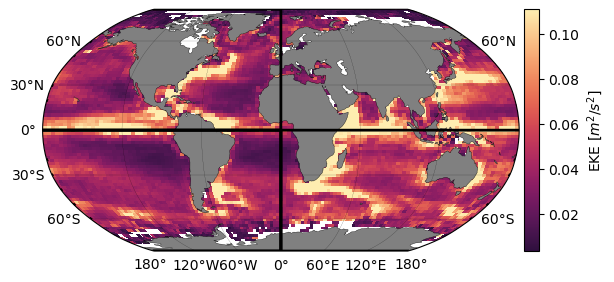

In [6]:
pf.plot_box([NW,NE,SW,SE])

In [ ]:
ds = prf.get_box(box_globe,2)

loading points complete


/home.ufs/amf2288/mambaforge-pypy3/envs/Argo_Oct_24/lib/python3.12/site-packages/argopy/data_fetchers/gdac_data.py:331: UserWarning: Found more than 50 files to load, this may take a while to process sequentially ! Consider using another data source (eg: 'erddap') or the 'parallel=True' option to improve processing time.
  warnings.warn(
  0%|          | 70/18727 [03:58<11:49:07,  2.28s/it]

In [ ]:
ds

In [ ]:
ds = ds.assign_attrs({"Fetched_uri":''})
ds

In [ ]:
ds.to_netcdf("/swot/SUM05/amf2288/sync-boxes/lon:({},{})_lat:({},{})_ds_z.nc".format(NW[0],NW[1],NW[2],NW[3]))

In [4]:
box_1x = [-10,0,-10,0,0,2000]   #error
box_1y = [-10,0,-20,-10,0,2000] #done
box_1z = [-10,0,-30,-20,0,2000] #done
box_1a = [-10,0,-40,-30,0,2000] #done
box_1b = [-10,0,-50,-40,0,2000] #done
box_1c = [-10,0,-60,-50,0,2000] #done
box_1d = [-10,0,-70,-60,0,2000] #done
box_long=[-10,-8,-70,-10,0,2000]

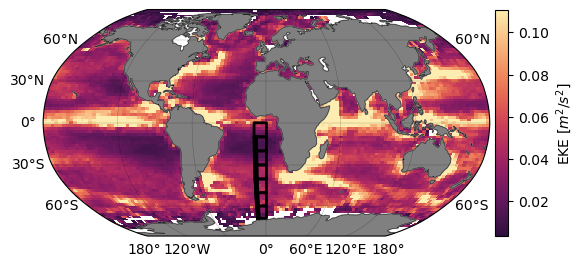

In [5]:
pf.plot_box([box_1x,box_1y,box_1z,box_1a,box_1b,box_1c,box_1d,box_long])

In [6]:
ds_z=ff.get_box(box_long,4)

loading points complete


100%|██████████| 708/708 [41:16<00:00,  3.50s/it]


to xarray complete
point to profile complete
interpolation complete
adding spice complete


In [7]:
ds['N_PROF'].attrs = {'name':'Fetched Profile Number'}
ds['PRES_INTERPOLATED'].attrs = {'name':'Interpolated Pressure', 'units':'dbar', 'notes':'interpolated to standard pressure grid of 2m'}

ds['N_PROF_NEW'].attrs = {'name':'Sequential Profile Number'}
ds['LATITUDE'].attrs = {'name':'Latitude', 'units':'°N'}
ds['LONGITUDE'].attrs = {'name':'Longitude', 'units':'°E'}
ds['month'].attrs = {'name':'Month'}
ds['year'].attrs = {'name':'Year'}
ds['MLD'].attrs = {'name':'Mixed Layer Depth', 'units':'m'}

ds['CT'].attrs = {'name':'Conservative Temperature', 'units':'°C'}
ds['SA'].attrs = {'name':'Absolute Salinity', 'units':'g kg-1'}
ds['SIG0'].attrs = {'name':'Potential Density', 'units':'kg m-1', 'notes':'referenced to 0 dbar'}
ds['SPICE'].attrs = {'name':'Spiciness', 'units':'kg m-1', 'notes':'referenced to 0 dbar'}                  
ds = ds.assign_attrs({"Fetched_uri":''})

In [8]:
ds_z

<xarray.Dataset>
Dimensions:                (N_PROF: 761, PRES_INTERPOLATED: 1000)
Coordinates:
  * N_PROF                 (N_PROF) int64 1215 1216 1217 1219 ... 4449 4450 4451
    TIME                   (N_PROF) datetime64[ns] 2015-11-25T23:34:22 ... 20...
    LATITUDE               (N_PROF) float64 -48.89 -48.29 ... -47.38 -46.22
    LONGITUDE              (N_PROF) float64 -8.963 -9.037 ... -8.285 -8.139
  * PRES_INTERPOLATED      (PRES_INTERPOLATED) int64 0 2 4 6 ... 1994 1996 1998
    N_PROF_NEW             (N_PROF) int64 0 1 2 3 4 5 ... 756 757 758 759 760
Data variables:
    CONFIG_MISSION_NUMBER  (N_PROF) int32 4 4 4 2 2 4 4 4 ... 8 8 8 8 10 10 10 6
    CT                     (N_PROF, PRES_INTERPOLATED) float64 3.279 ... 1.839
    CYCLE_NUMBER           (N_PROF) int32 116 117 118 106 ... 119 120 121 101
    DATA_MODE              (N_PROF) <U1 'D' 'D' 'D' 'D' 'D' ... 'D' 'D' 'D' 'D'
    DIRECTION              (N_PROF) <U1 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER        (N_PROF) int32 1901599 1901599 ... 7900202 7900203
    PRES                   (N_PROF, PRES_INTERPOLATED) float32 1.1 ... 1.998e+03
    PSAL                   (N_PROF, PRES_INTERPOLATED) float32 33.82 ... 34.76
    SA                     (N_PROF, PRES_INTERPOLATED) float64 33.98 ... 34.93
    SIG0                   (N_PROF, PRES_INTERPOLATED) float64 26.92 ... 27.8
    TEMP                   (N_PROF, PRES_INTERPOLATED) float32 3.273 ... 1.976
    SPICE                  (N_PROF, PRES_INTERPOLATED) float64 -0.5596 ... -0...
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         /swot/SUM05/dbalwada/Argo_sync
    Fetched_by:           amf2288
    Fetched_date:         2023/08/03
    Fetched_constraints:  [x=-10.00/-8.00; y=-70.00/-10.00; z=0.0/2000.0]
    Fetched_uri:          
    history:              Variables filtered according to DATA_MODE; Variable...

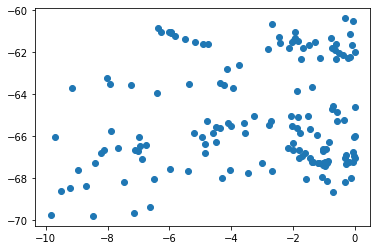

In [39]:
plt.scatter(ds_z.LONGITUDE, ds_z.LATITUDE)

In [9]:
ds_z.to_netcdf("202206_boxes/lon:({},{})_lat:({},{})_ds_z.nc".format(box_long[0],box_long[1],box_long[2],box_long[3]))

In [ ]:
erddap_loader=ArgoDataFetcher(src'erddap',parallel=True,progress=True)

In [41]:
gmaze_loader=ArgoDataFetcher(src='gdac',ftp='https://data-argo.ifremer.fr/',parallel=True,progress=True)

In [ ]:
usa_loader=ArgoDataFetcher(src='gdac',ftp='ftp://usgodae.org/pub/outgoing/argo',parallel=True,progress=True)

In [45]:
ds=argo_loader.region(box_1x)
print('loading points complete')
ds=ds.to_xarray()
print('to xarray complete')

loading points complete


100%|██████████| 193/193 [14:02<00:00,  4.37s/it]


ValueError: 'PROFILE_PSAL_QC' is not present in all datasets.

In [ ]:
ds=ds.argo.teos10(['CT','SA','SIG0'])
ds=ds.argo.point2profile()
print('point to profile complete')

In [7]:
def test_get_box(box,sample_min):
    '''Takes latitude/longitude/depth data and a sample rate and returns an xarray with CT, SA, SIG0, and SPICE interpolated to a pressure grid of 2m. 
    
    box: lat/lon in the form: box=[lon_min, lon_max, lat_min, lat_max, depth_min, depth_max]
    sample_min: minimum sample rate [m]
    '''
    
    ds=argo_loader.region(box)
    print('loading points complete')
    
    ds=ds.to_xarray()
    print('to xarray complete')
    
    ds=ds.argo.teos10(['CT','SA','SIG0'])
    ds=ds.argo.point2profile()
    print('point to profile complete')
    
    ds_interp=get_ds_interp(ds,0,2000,sample_min)
    print('interpolation complete')
    
    ds_interp['SPICE'] = gsw.spiciness0(ds_interp.SA,ds_interp.CT).rename('SPICE')
    print('adding spice complete')
        
    return ds_interp

In [8]:
test = test_get_box(box_medi,4)

loading points complete


100%|██████████| 240/240 [11:02<00:00,  2.76s/it]


AttributeError: 'Dataset' object has no attribute 'PSAL'

In [18]:
ds=argo_loader.region(box_medi)

In [19]:
ds = ds.data

In [20]:
ds

<xarray.Dataset>
Dimensions:                (N_POINTS: 1405747)
Coordinates:
  * N_POINTS               (N_POINTS) int64 0 1 2 3 ... 1405744 1405745 1405746
    TIME                   (N_POINTS) datetime64[ns] 1999-09-29T03:28:00.0000...
    LATITUDE               (N_POINTS) float64 42.0 42.0 42.0 ... 42.8 42.8 42.8
    LONGITUDE              (N_POINTS) float64 -16.0 -16.0 ... -19.78 -19.78
Data variables:
    CONFIG_MISSION_NUMBER  (N_POINTS) int32 1 1 1 1 1 1 1 ... 65 65 65 65 65 65
    CYCLE_NUMBER           (N_POINTS) int32 0 0 0 0 0 0 ... 226 226 226 226 226
    DATA_MODE              (N_POINTS) <U1 'D' 'D' 'D' 'D' ... 'A' 'A' 'A' 'A'
    DIRECTION              (N_POINTS) <U1 'D' 'D' 'D' 'D' ... 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER        (N_POINTS) int32 69003 69003 ... 6901193 6901193
    POSITION_QC            (N_POINTS) int32 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    PRES                   (N_POINTS) float32 58.0 63.0 ... 1.997e+03 1.999e+03
    PRES_QC                (N_POINTS) int32 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    TEMP                   (N_POINTS) float32 15.02 14.69 14.41 ... 3.689 3.684
    TEMP_QC                (N_POINTS) int32 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    TIME_QC                (N_POINTS) int32 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         /swot/SUM05/dbalwada/Argo_sync
    Fetched_by:           amf2288
    Fetched_date:         2023/07/27
    Fetched_constraints:  [x=-20.00/-10.00; y=35.00/45.00; z=0.0/2000.0]
    Fetched_uri:          /swot/SUM05/dbalwada/Argo_sync/dac/coriolis/1900350...
    history:              Variables filtered according to DATA_MODE; Variable...

In [16]:
ds.PSAL.dropna('N_POINTS')

AttributeError: 'Dataset' object has no attribute 'PSAL'

In [ ]:
for n in range(0,len(ds.N_PROF)):
    

In [ ]:
'''
methods are also functions, but specific to the class they're applied to
class (animals) --> subclass (dogs) --> object (golden retriever)
open_mfdataset() from xarray, for opening data in multiple netcdfs
1) write loop opening all files yourself, check for PSAL, if not there remove file
2) go into open_mfdataset() and see if there's a loop there to exploit instead

locally install repo (pip install -e??)
uses the code from the local repo instead
then make changes to repo: print statement in part of the code we think is happening
then work on loops, etc.


'''

In [ ]:
def to_xarray(self, errors: str = "ignore"):
        """ Load Argo data and return a :class:`xarray.Dataset`

        Parameters
        ----------
        errors: str, default='ignore'
            Define how to handle errors raised during data URIs fetching:

                - 'ignore' (default): Do not stop processing, simply issue a debug message in logging console
                - 'silent':  Do not stop processing and do not issue log message
                - 'raise': Raise any error encountered

        Returns
        -------
        :class:`xarray.Dataset`
        """
        if (
            len(self.uri) > 50
            and isinstance(self.method, str)
            and self.method == "sequential"
        ):
            warnings.warn(
                "Found more than 50 files to load, this may take a while to process sequentially ! "
                "Consider using another data source (eg: 'erddap') or the 'parallel=True' option to improve processing time."
            )
        elif len(self.uri) == 0:
            raise DataNotFound("No data found for: %s" % self.indexfs.cname)

        # Download data:
        ds = self.fs.open_mfdataset(
            self.uri, #list of all float files?
            method=self.method,
            concat_dim="N_POINTS",
            concat=True,
            preprocess=self._preprocess_multiprof,
            progress=self.progress,
            errors=errors,
            open_dataset_opts={'xr_opts': {'decode_cf': 1, 'use_cftime': 0, 'mask_and_scale': 1}},
        )

        # Data post-processing:
        ds["N_POINTS"] = np.arange(
            0, len(ds["N_POINTS"])
        )  # Re-index to avoid duplicate values
        ds = ds.set_coords("N_POINTS")
        ds = ds.sortby("TIME")

        # Remove netcdf file attributes and replace them with simplified argopy ones:
        ds.attrs = {}
        if self.dataset_id == "phy":
            ds.attrs["DATA_ID"] = "ARGO"
        if self.dataset_id == "bgc":
            ds.attrs["DATA_ID"] = "ARGO-BGC"
        ds.attrs["DOI"] = "http://doi.org/10.17882/42182"
        ds.attrs["Fetched_from"] = self.server
        ds.attrs["Fetched_by"] = getpass.getuser()
        ds.attrs["Fetched_date"] = pd.to_datetime("now", utc=True).strftime("%Y/%m/%d")
        ds.attrs["Fetched_constraints"] = self.cname()
        if len(self.uri) == 1:
            ds.attrs["Fetched_uri"] = self.uri[0]
        else:
            ds.attrs["Fetched_uri"] = ";".join(self.uri)

        return ds

In [ ]:
print(ds_z.SIG0.values.min(), ds_z.SIG0.values.max())

In [ ]:
rho_grid = np.linspace(26.6, 28, 1001)

In [ ]:
ds_rho = df.interpolate2density_prof(ds_z, rho_grid)

In [ ]:
ds_rho

In [ ]:
ds_rho.to_netcdf("202206_boxes/lon:({},{})_lat:({},{})_ds_rho.nc".format(box[0],box[1],box[2],box[3]))

## Load by float (coordinate: distance)

In [ ]:
float_ID = 6901265

In [ ]:
ds_z = ff.get_float(float_ID, 4)

In [ ]:
ds_z = ds_z.assign_attrs({"Fetched_uri":''})

In [ ]:
ds_z

In [ ]:
ds_z.to_netcdf("202206_floats/float_ID:({})_ds_z.nc".format(float_ID))

In [ ]:
print(ds_z.SIG0.values.min(), ds_z.SIG0.values.max())

In [ ]:
rho_grid = np.linspace(26.4, 28, 1001)

In [ ]:
ds_rho = df.interpolate2density_prof(ds_z, rho_grid)

In [ ]:
ds_rho

In [ ]:
ds_rho.to_netcdf("202206_floats/float_ID:({})_ds_rho.nc".format(float_ID))

## Loading Boxes by Degree

In [132]:
lons = np.arange(-180,181,4)
lats = np.arange(-90,91,4)

boxes=[]

for n in range(0,len(lons)-1):
    for m in range(0,len(lats-1)):
        lon_min = lons[n]
        lon_max = lons[n+1]
        lat_min = lats[n]
        lat_max = lats[n+1]
        box_n = np.array([lon_min, lon_max, lat_min, lat_max])
        boxes.append(box_n)

IndexError: index 46 is out of bounds for axis 0 with size 46

In [136]:
n=0
lons[n+1]

-176

In [64]:
from argopy import IndexFetcher as ArgoIndexFetcher

box_bad=[-15,-14,36.5,37]#, '2000-01-01', '2021-06'] # need to remove pressure poinds because the region function for this index fetcher seems a bit different.

idx = ArgoIndexFetcher(src='gdac',dataset='phy',mode='standard',
                            ftp="/swot/SUM05/dbalwada/202203-ArgoData").region(box_bad).load()
idx.index

,file,date,latitude,longitude,ocean,profiler_code,institution_code,date_update,wmo,institution,profiler
0,aoml/1900041/profiles/D1900041_067.nc,2004-01-02 22:27:49,36.687,-14.002,A,851,AO,2019-05-05 16:50:37,1900041,"AOML, USA","Solo, Seabird conductivity sensor"
1,aoml/1900749/profiles/D1900749_015.nc,2007-05-08 11:55:38,36.716,-14.029,A,851,AO,2019-05-23 14:23:26,1900749,"AOML, USA","Solo, Seabird conductivity sensor"
2,aoml/1900778/profiles/D1900778_123.nc,2011-02-08 11:01:58,36.814,-14.919,A,851,AO,2019-05-30 16:23:14,1900778,"AOML, USA","Solo, Seabird conductivity sensor"
3,coriolis/3901932/profiles/D3901932_118.nc,2021-08-23 06:22:00,36.948,-14.746,A,844,IF,2021-12-01 18:03:09,3901932,"Ifremer, France","Arvor, Seabird conductivity sensor"
4,coriolis/6900137/profiles/D6900137_058.nc,2006-01-21 04:15:00,36.907,-14.205,A,840,IF,2015-10-19 19:21:25,6900137,"Ifremer, France","Provor, no conductivity"
5,coriolis/6900137/profiles/D6900137_059.nc,2006-01-31 04:15:00,36.858,-14.127,A,840,IF,2015-10-19 19:21:26,6900137,"Ifremer, France","Provor, no conductivity"
6,coriolis/6900137/profiles/D6900137_060.nc,2006-02-10 04:39:00,36.954,-14.219,A,840,IF,2015-10-19 19:21:27,6900137,"Ifremer, France","Provor, no conductivity"
7,coriolis/6900137/profiles/D6900137_061.nc,2006-02-20 03:56:00,36.988,-14.305,A,840,IF,2015-10-19 19:21:27,6900137,"Ifremer, France","Provor, no conductivity"
8,coriolis/6900231/profiles/D6900231_036.nc,2004-12-12 17:48:03,36.642,-14.533,A,846,IF,2019-06-03 19:58:58,6900231,"Ifremer, France","Webb Research, Seabird sensor"
9,coriolis/6900231/profiles/D6900231_037.nc,2004-12-22 18:16:56,36.644,-14.734,A,846,IF,2019-06-03 19:58:59,6900231,"Ifremer, France","Webb Research, Seabird sensor"


In [34]:
float_IDs = [1900041,1900749,]

argopy.fetchers.ArgoIndexFetcher